# Graph Coloring

This page explains how to solve the graph coloring problem using Amplify


## Formulation of graph coloring problem


The graph coloring problem is a problem of assigning colors to the vertices of a certain graph under given constraints. The most typical problem is to color a graph so that the adjacent vertices have different colors.

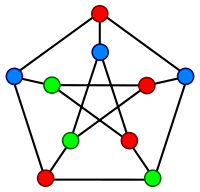

In a plane graph (map), the `four color theorem <https://en.wikipedia.org/wiki/Four_color_theorem>`_ states that four colors are enough to color any map so that all adjacent regions in the map have distinct colors. However, it is not obvious how to implement such coloring.

Several application examples are known for the graph coloring problem, such as scheduling problems related to allocation of conference rooms, machines, tasks, etc., register allocation by a compiler, frequency allocation in a mobile phone network. Here, we demonstrate a way to solve a graph coloring problem using an Ising machine by coloring the prefectures in Japan.

In order to use Ising machines, we consider how to express the states of the coloring of the graph in terms of binary variables. It can be expressed by assigning $0$ or $1$ to each region using four variables as follows:

| Region | Red | Green | Blue | Yellow |
|--------|-----|-------|------|--------|
| 1      | 0   | 0     | 1    | 0      |
| 2      | 0   | 1     | 0    | 0      |
| 3      | 0   | 0     | 1    | 0      |
| 4      | 1   | 0     | 0    | 0      |

    
This example means assigning blue to region $1$, green to region $2$, blue to region $3$, and red to region $4$. We will represent each variable in the above table as $q_{i,c}$ using the region index $i$ and the color index $c$. Therefore, the number of variables required is $NC$ for the number of regions $N$ and the number of colors $C$.

The following constraints are imposed on the variables accordingly to the definition of the coloring problem.

* Paint one region with one color
* Adjacent regions must have distinct colors

When these are formulated, they are expressed as follows:

**Constraints**

$$
    \sum_{c = 0}^{C-1}{ q_{i,c} } = 1 \quad i \in \left\{0, 1, \cdots, N - 1 \right\} \\
    \sum_{\left(i, j \right) \in E}{ q_{i,c} q_{j,c} } = 0
$$

Here, $E$ represents a set of pairs of adjacent regions on the graph. Please note that the variable index starts at $0$ for the convenience of later program coding.


## Creating a Problem

We use Python's [japanmap](https://pypi.org/project/japanmap/) module to work with maps of Japan. You can get the prefecture name, adjacency information, etc. using the prefecture code ($1$-$47$).

First, we define the colors and prepare the variable table.

In [ ]:
from amplify import BinaryPoly, gen_symbols
import japanmap as jm

colors = ["red", "green", "blue", "yellow"]
num_colors = len(colors)
num_region = len(jm.pref_names) - 1  # Obtain the number of prefectures

q = gen_symbols(BinaryPoly, num_region, num_colors)

In [ ]:
q

### Note

Since all the coefficients appearing in the constraint polynomial are integers, it is possible to use `amplify.BinaryIntPoly` instead of `amplify.BinaryPoly`


Next, we create constraint conditions. One-hot constraints can be written using the `amplify.constraint.equal_to` function, and constraints with a minimum value of 0 can be written using the `amplify.constraint.penalty` function as follows.


In [ ]:
from amplify import sum_poly
from amplify.constraint import equal_to, penalty

# Constraints on each region
reg_constraints = [
    equal_to(sum_poly([q[i][c] for c in range(num_colors)]), 1)
    for i in range(num_region)
]

# Constraints between adjacent regions
adj_constraints = [
    # Note that the prefecture code and the array index are off by one
    penalty(q[i][c] * q[j - 1][c])
    for i in range(num_region)
    for j in jm.adjacent(i + 1)  # j: Adjacent prefecture code
    if i + 1 < j
    for c in range(num_colors)
]

constraints = sum(reg_constraints) + sum(adj_constraints)

Adjacent information can be obtained by entering the state code in the `japanmap.adjacent` function. Note that the index for `q` and the state code differ by $1$.


### Note

For the constraints that take the minimum value $0$, it is equivalent to first summing all the conditions and then creating a single constraint object. You can also write the constraints between adjacent regions as follows:

```python
# Constraints between adjacent regions
adj_constraints = [
    # Note that the prefecture code and the array index are off by one
    penalty(sum_poly(q[i][c] * q[j - 1][c]) for c in range(num_colors))
    for i in range(num_region)
    for j in jm.adjacent(i + 1)  # j: Adjacent prefecture code
    if i + 1 < j
]
```

Now we completed the preparation for the formulation.

## Ising machine execution

We create a client for the Ising machine and set the parameters. We then create a solver by setting the configured client.

In [ ]:
from amplify import Solver
from amplify.client import FixstarsClient

client = FixstarsClient()
client.parameters.timeout = 5000  # Timeout is 5 seconds

solver = Solver(client)

We create a logical model from the constraints, execute the Ising machine as follows, and obtain the result.

In [ ]:
from amplify import BinaryQuadraticModel

model = BinaryQuadraticModel(constraints)
result = solver.solve(model)
if len(result) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

values = result[0].values

### Note

If the length of the ``result`` object is empty, it means that no solution that satisfies the constraint condition was obtained. In this case, it is necessary to change the parameters of the Ising machine.

## Analysis of results

`values` is a dictionary that represents the mapping between input variables and solution values. Since it is difficult to handle it as it is, we decode it into the same format as the variable table `q` as follows.

In [ ]:
from amplify import decode_solution

q_values = decode_solution(q, values, 1)

We convert the result to a dictionary with ``{prefecture name: color}`` format. First, we obtain the index with the value of 1 in each row of ``q_values``, by using a numpy function as shown below. After that, `japanmap.pref_names` is used to convert the row indices to prefecture names, and we create the dictionary by pairing them with the corresponding colors.

In [ ]:
import numpy as np

color_indices = np.where(np.array(q_values) == 1)[1]
color_map = {
    jm.pref_names[i + 1]: colors[color_indices[i]] for i in range(len(color_indices))
}

In [ ]:
color_map

Lastly we display the colored map. It is plotted as follows:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 6, 6
plt.imshow(jm.picture(color_map))
plt.show()